# 画像生成AIをつくろう（GAN編）

## 概要

- Generative Adversarial Network （敵対的生成ネットワーク）
- Generator と Discriminator の二つのニューラルネットワークで構成される
- [わかりやすいイメージ](https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/d1dbe44f-1061-405d-9f32-d1d4bde70860/gr1_lrg.jpg)
- [論文](https://arxiv.org/abs/1406.2661)

## 学習の仕組み

$$
\min_{G}\max_{D} V(D, G) = \mathbb{E}_{x\sim p_{\text{data}}(x)}[\log{D(x)}] + \mathbb{E}_{z\sim{p_z(z)}}[\log{(1-D(G(z)))}]\tag{1}
$$

- GANの仕組みを表現した数式
- 左辺
    - $V(D, G)$ 識別器（Discriminator）と生成器（Generator）の価値関数（Value function）
    - 生成器は価値関数を最小化したい（$\min_{G}$）
    - 識別器は価値関数を最大化したい（$\max_{D}$）
- 右辺第一項目
    - 本物の画像を本物であると正しく識別できる期待値
    - $x\sim p_{\text{data}(x)}$ 訓練データからサンプリングした本物の画像$x$
    - ${D(x)}$ 本物の画像を入力した時に正しく識別できる確率
    - $\mathbb{E}$ 識別器の出力の対数の期待値
    - 本物の画像を本物（$=1$）であると見抜くと価値関数を最大化できる
- 右辺第二項目
    - 偽物の画像を偽物であると正しく識別できる期待値
    - $z\sim p_z(z)$ 一様分布からサンプリングした潜在変数 $z$
    - $G(z)$ 潜在変数から生成した偽物の画像
    - $D(G(z))$ 偽物の画像を入力した時に誤って識別する確率
    - $1 - D(G(z))$ 偽物の画像を入力した時に正しく識別できる確率
    - 偽物の画像を偽物（$=0$）であると見抜くと価値関数を最大化できる
    - 偽物の画像を本物（$=1$）のように生成できると価値関数を最小化できる
- 生成器と識別器は単純なパーセプトロンで構成されており、VAEと異なり尤度推定なしで学習できるメリットがある

![](image/_page_2_Figure_4.jpeg)

- 青色: 識別器の分布。識別器は本物の画像と偽物の画像を見分けるように学習する。
- 黒色: 本物の画像の分布 $p_x$
- 緑色: 生成器で出力した偽物の画像の分布 $p_g(G)$
- (a) 訓練前の状態
- (b) 識別器を学習した状態
- (c) 生成器を学習した状態
- (d) 識別器と生成器が最適化された状態（識別器の出力が見分けのつかない確率 $=1/2$ に落ち着く）

![](image/algorithm_1.png)


- $k$ ディスクリミネイターのステップ数（デフォルトは $1$）
- 前半：式１を使い、ディスクリミネイターを学習
- 後半：式１の右辺の第二項を使い、ジェネレイターを学習

## 実装

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [3]:
# 識別機は入力を受け取り、それが本物か偽物かを判定する
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)

        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)

        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)

        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)

        logit_out = self.fc4(x) # ロジットを出力

        return logit_out

In [4]:
# 生成機はノイズをサンプリングし、それを元に偽物の画像を生成する
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)

        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)

        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)

        self.fc4 = nn.Linear(in_features=128, out_features=out_features)

        self.dropout = nn.Dropout(0.3)
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)

        x = self.fc4(x)
        tanh_out = self.tanh(x) # -1から1を出力

        return tanh_out

In [52]:
# GPUがある場合はcudaを使い、ない場合はcpuを使う
device = "cuda" if torch.cuda.is_available() else "cpu"

# 潜在空間の次元数
z_size = 100

# ログ用
discriminator_losses = []
generator_losses = []

# ログ用に画像を生成するための潜在変数
z_batch = 16
fixed_z = torch.from_numpy(np.random.uniform(-1, 1, size=(z_batch, z_size))).float().to(device)
fixed_samples = []

# ニューラルネットワークのパラメータを初期化
discriminator = Discriminator(in_features=28*28, out_features=1).to(device)
generator = Generator(in_features=z_size, out_features=28*28).to(device)

# 最適化関数のパラメータを初期化
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.002)

# 損失関数はBinary Cross Entropyを使用
loss_function = nn.BCEWithLogitsLoss()

num_epochs = 30

for epoch in range(num_epochs):
    discriminator.train()
    generator.train()

    discriminator_batch_loss_sum = 0
    generator_batch_loss_sum = 0

    for batch_index, (real_image, _) in enumerate(data_loader):
        # 1-1. 識別器の最適化関数の勾配を初期化
        discriminator_optimizer.zero_grad()

        # 1-2. 本物の画像で識別して誤差を計算
        real_image = (real_image.to(device) * 2) - 1 # 0〜1の値を-1〜1の値に変換
        real_predicted = discriminator(real_image)

        targets = torch.ones(len(real_image)).to(device) # 正解は全て1
        discriminator_real_loss = loss_function(real_predicted.squeeze(), targets)

        # 1-3. 偽物の画像を識別して誤差を計算
        with torch.no_grad():
            # 潜在空間のベクトルを生成
            z = np.random.uniform(-1, 1, size=(len(real_image), z_size))
            z = torch.from_numpy(z).float().to(device)
            # 生成器で偽物の画像を生成
            fake_images = generator(z)
        
        fake_predicted = discriminator(fake_images)

        targets = torch.zeros(len(fake_images)).to(device) # 正解は全て0
        discriminator_fake_loss = loss_function(fake_predicted.squeeze(), targets)

        # 1-4. 誤差を合計
        discriminator_loss = discriminator_real_loss + discriminator_fake_loss

        # 1-5. 誤差を逆伝播
        discriminator_loss.backward()

        # 1-6. 識別器のパラメータを更新
        discriminator_optimizer.step()

        # 誤差をログに記録
        discriminator_batch_loss_sum += discriminator_loss.item()

        # 2-1. 生成器の最適化関数の勾配を初期化
        generator_optimizer.zero_grad()

        # 2-2. 偽の画像を生成して識別器で識別 
        z = np.random.uniform(-1, 1, size=(len(real_image), z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = generator(z)
        fake_predicted = discriminator(fake_images)
        targets = torch.ones(len(fake_images)).to(device) # 正解は全て1
        generator_loss = loss_function(fake_predicted.squeeze(), targets)

        # 2-3. 誤差を逆伝播
        generator_loss.backward()

        # 2-4. 生成器のパラメータを更新
        generator_optimizer.step()

        # 2-5. 誤差をログに記録
        generator_batch_loss_sum += generator_loss.item()

        # 100バッチごとにログを表示
        if batch_index % 100 == 0:
            print(f"バッチ {batch_index + 1}/{len(data_loader)},"
                f"識別器の誤差:{discriminator_loss.item():.6f},"
                f"生成器の誤差:{generator_loss.item():.6f}")

    # エポックごとの誤差をログに記録
    discriminator_loss = discriminator_batch_loss_sum / len(data_loader)
    generator_loss = generator_batch_loss_sum / len(data_loader)
    discriminator_losses.append(discriminator_loss)
    generator_losses.append(generator_loss)

    # エポックごとにログを表示
    print(f"エポック {epoch + 1}/{num_epochs},"
        f"識別器の損失:{discriminator_loss:.6f},"
        f"生成器の損失:{generator_loss:.6f}")

    # エポックごとに画像を生成して保存
    generator.eval()
    fixed_samples.append(generator(fixed_z).detach().cpu())

print("学習が完了しました")

バッチ 1/938,識別器の誤差:1.384558,生成器の誤差:0.607573
バッチ 101/938,識別器の誤差:1.778571,生成器の誤差:1.098452
バッチ 201/938,識別器の誤差:0.520922,生成器の誤差:4.333160
バッチ 301/938,識別器の誤差:0.950987,生成器の誤差:1.548170
バッチ 401/938,識別器の誤差:0.937569,生成器の誤差:3.687410
バッチ 501/938,識別器の誤差:0.865371,生成器の誤差:1.305993
バッチ 601/938,識別器の誤差:1.401116,生成器の誤差:0.754807
バッチ 701/938,識別器の誤差:0.720663,生成器の誤差:2.821381
バッチ 801/938,識別器の誤差:1.674908,生成器の誤差:0.677042
バッチ 901/938,識別器の誤差:1.415424,生成器の誤差:0.509322
エポック 1/30,識別器の損失:1.157621,生成器の損失:1.523828
バッチ 1/938,識別器の誤差:0.967986,生成器の誤差:3.396893
バッチ 101/938,識別器の誤差:0.963664,生成器の誤差:4.061014
バッチ 201/938,識別器の誤差:1.335855,生成器の誤差:0.626782
バッチ 301/938,識別器の誤差:1.274750,生成器の誤差:0.997710
バッチ 401/938,識別器の誤差:1.284049,生成器の誤差:0.702733
バッチ 501/938,識別器の誤差:1.102141,生成器の誤差:0.828826
バッチ 601/938,識別器の誤差:1.342772,生成器の誤差:0.832381
バッチ 701/938,識別器の誤差:1.334680,生成器の誤差:0.757676
バッチ 801/938,識別器の誤差:1.436163,生成器の誤差:0.601829
バッチ 901/938,識別器の誤差:1.035401,生成器の誤差:0.861468
エポック 2/30,識別器の損失:1.160550,生成器の損失:1.120012
バッチ 1/938,識別器の誤差:0.718508,生成器の誤差:1.53527

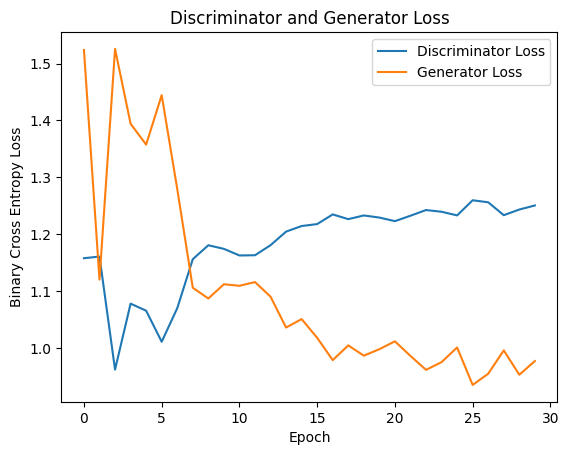

In [53]:
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.plot(generator_losses, label="Generator Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Discriminator and Generator Loss")
plt.show()

In [54]:
def view_samples(epoch):
    print(f"エポック{epoch}の生成画像")
    s = fixed_samples[epoch - 1]
    s = (s + 1) / 2 # -1〜1の値を0〜1の値に変換
    for i in range(len(s)):
        image = s[i].view(28, 28).detach().numpy()
        axes = plt.subplot(4, 4, i + 1)
        axes.imshow(image, cmap="gray")
        axes.axis("off")

エポック1の生成画像


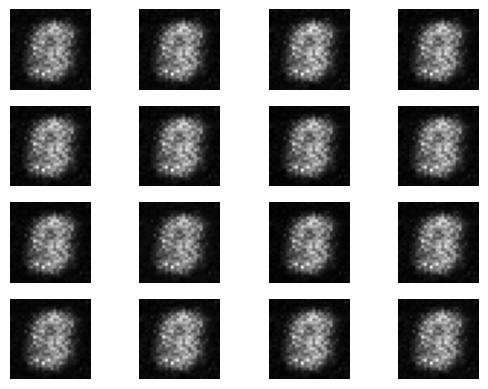

In [55]:
view_samples(1)

エポック5の生成画像


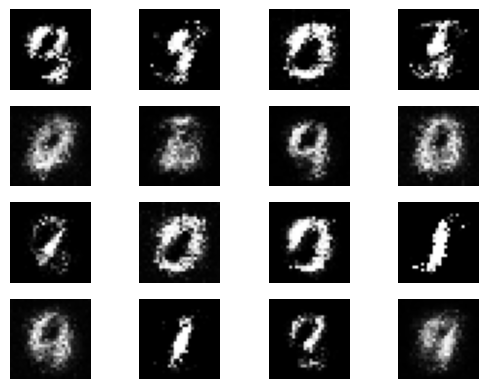

In [56]:
view_samples(5)

エポック20の生成画像


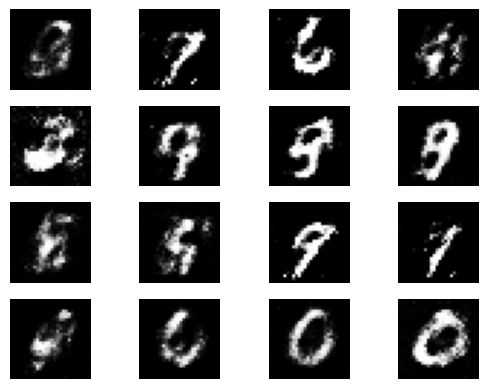

In [57]:
view_samples(20)

本物である確率: 34%


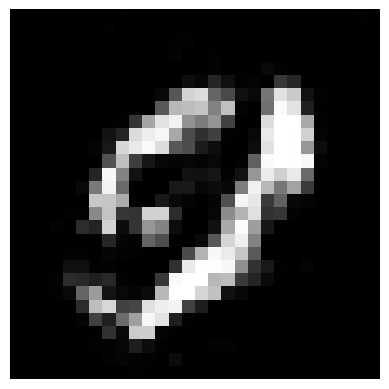

In [58]:

# 入力に偽物の画像を使用
generator.to("cpu")
generator.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
input_image = generator(z)

# 入力に本物の画像を使用
# random_index = np.random.randint(0, len(train_dataset))
# input_image = train_dataset[random_index][0] * 2 - 1

# 入力した画像を表示
image = (input_image + 1) / 2 # -1〜1の値を0〜1の値に変換
image = image.view(28, 28).detach().numpy()
plt.imshow(image, cmap="gray")
plt.axis("off")


# 入力した画像が本物である確率を計算
discriminator.to("cpu")
discriminator.eval()
result = discriminator(input_image.view(1, 28*28))
result = torch.sigmoid(result).item()
print(f"本物である確率: {int(result * 100)}%")